Project 4 - Advanced Lane Finding - Report. Vilas Chitrakaran. Feb 2017

## Executive Summary

__TODO__
* Make coding style consistent

## Camera Calibration

Corner detection failed on  ./camera_cal/calibration4.jpg
Corner detection failed on  ./camera_cal/calibration1.jpg
Corner detection failed on  ./camera_cal/calibration5.jpg
Camera intrinsic matrix:
 [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Camera distortion parameters:
 [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]
Test undistortion on one of the images


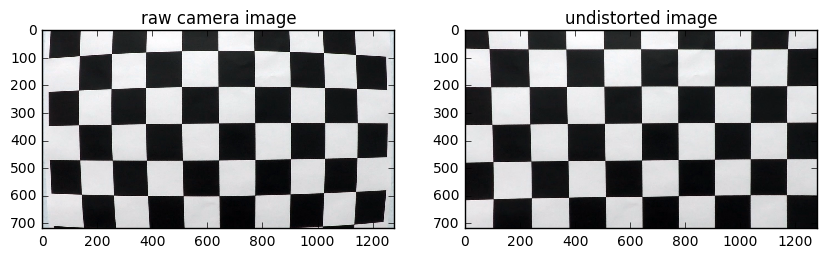

In [1]:
#=====================================================================
# Camera calibration
# Note: The following comes from code provided in examples directory

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt5
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objPoints = [] # 3d points in real world space
imgPoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), cv2.CALIB_CB_ADAPTIVE_THRESH)

    # If found, add object points, image points
    if ret == True:
        objPoints.append(objp)
        imgPoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.figure()
        cv2.imshow('img',img)
        cv2.waitKey(500)
    else:
        print("Corner detection failed on ", fname)

cv2.destroyAllWindows()

# now calibrate the camera
ret, camMat, distParams, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1], None, None)
print('Camera intrinsic matrix:\n', camMat)
print('Camera distortion parameters:\n', distParams)

# test undistortion
img = cv2.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, camMat, distParams, None, camMat)
cv2.imwrite('./output_images/undistorted_calibration_board.png', undist)

print('Test undistortion on one of the images')
f, axarr = plt.subplots(1,2,figsize=(10,10))
axarr[0].imshow(img)
axarr[0].set_title('raw camera image')
axarr[1].imshow(undist)
axarr[1].set_title('undistorted image');


__NOTE__: As seen above, the undistortion is not perfect. There is visible distortion in the top left corner.

## Setup Perspective Transform

* Find an image with straight road
* __undistort it__
* pick four points, transform to top view
    * use DVLA info on lane markings to determine correct ratios
* test on an image

Points mapped from:
 [[  710.   470.]
 [ 1020.   700.]
 [  260.   700.]
 [  570.   470.]]
Points mapped to:
 [[ 1020.     0.]
 [ 1020.   720.]
 [  260.   720.]
 [  260.     0.]]
Perspective matrix:
 [[ -6.74382716e-01  -1.53086420e+00   1.07160494e+03]
 [ -7.66053887e-15  -2.11111111e+00   9.92222222e+02]
 [ -1.22514845e-17  -2.39197531e-03   1.00000000e+00]]
Inverse perspective matrix:
 [[ -1.48283753e+00   5.83720170e+00  -4.20278522e+03]
 [  2.54187804e-14   3.81301079e+00  -3.78335404e+03]
 [  4.26341341e-17   9.12062766e-03  -8.04968944e+00]]


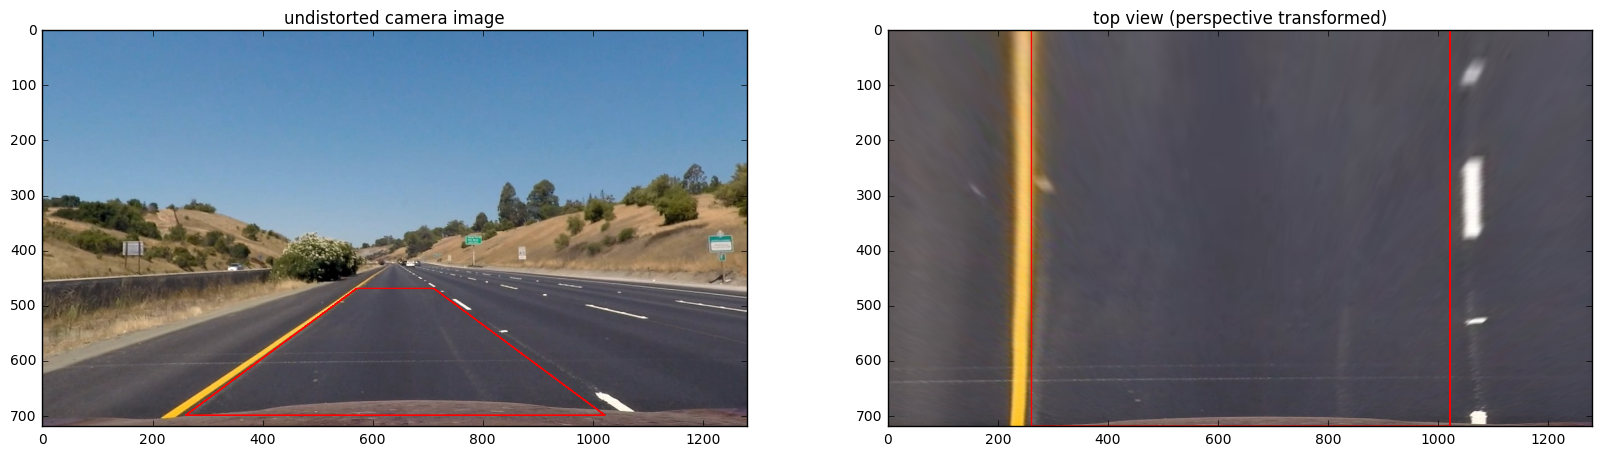

In [2]:
#=====================================================================
# Setup perspective transform

# generate perspective transform from src points defined as a trapeziod to
# dst defined as a rectangle
# xCenter - x-coord of vertical centerline
# xOffsetTop - x offset of left and right edges at the top
# xOffsetBottom - x offset of left and right edges at the bottom
# yTop - y-coord at the top
# yBottom - y-coord at the bottom
def setup_perspective(xCenter, xOffsetTop, xOffsetBottom, yTop, yBottom):
    
    # These points were selected from test_images/straight_lines1.jpg after applying undistortion
    image = cv2.imread('./test_images/straight_lines1.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(image, camMat, distParams, None, camMat)
    imgSz = (image.shape[1], image.shape[0])

    # source points
    imgSrcPts = np.float32(
        [[xCenter+xOffsetBottom,yBottom],
         [xCenter+xOffsetTop,yTop],
         [xCenter-xOffsetTop,yTop],
         [xCenter-xOffsetBottom,yBottom]])

    # destination points
    imgDstPts = np.float32(
        [[xCenter+xOffsetTop,0],
         [xCenter+xOffsetTop,image.shape[0]],
         [xCenter-xOffsetTop,image.shape[0]],
         [xCenter-xOffsetTop,0]])

    # generate the perspective matrix
    persMat = cv2.getPerspectiveTransform(imgSrcPts, imgDstPts)

    transformed = cv2.warpPerspective(undist, persMat, imgSz, flags=cv2.INTER_LINEAR)
    
    # draw src and dst guide lines on both images
    undist = cv2.polylines(undist, np.int32([imgSrcPts]), True, (255,0,0), 2)
    transformed = cv2.polylines(transformed, np.int32([imgDstPts]), True, (255,0,0), 2)
    
    # write images so I can inspect them manually
    cv2.imwrite('./output_images/top_view.png', cv2.cvtColor(transformed, cv2.COLOR_RGB2BGR))

    print('Points mapped from:\n', imgSrcPts)
    print('Points mapped to:\n', imgDstPts)

    f, axarr = plt.subplots(1,2,figsize=(20,10))
    axarr[0].imshow(undist)
    axarr[0].set_title('undistorted camera image')
    axarr[1].imshow(transformed)
    axarr[1].set_title('top view (perspective transformed)');
    f.savefig('./output_images/perspective_transformed.png')
    return persMat

# set the transformation source points interactively
#from IPython.html import widgets
#from IPython.html.widgets import interact
#from IPython.display import display

#persMat = interact(setup_perspective, 
#                    xCenter=(639,641), 
#                    xOffsetTop=(300,400),
#                    xOffsetBottom=(90,130), 
#                    yTop=(600,700), 
#                    yBottom=(450,550))

# Good starting point: xCenter=640, xOffsetTop=316, xOffsetBottom=110, yTop=650, yBottom=500
# Alt starting point: xCenter=640, xOffsetTop=380, xOffsetBottom=40, yTop=700, yBottom=450
persMat= setup_perspective(xCenter=640, xOffsetTop=380, xOffsetBottom=70, yTop=700, yBottom=470)

print('Perspective matrix:\n', persMat)
retval,invPersMat = cv2.invert(persMat)
if retval is 0:
    print('Cannot invert perspective matrix')
else:
    print('Inverse perspective matrix:\n', invPersMat)

## Image to World Scaling

According to lesson notes, as per US roadway design regulations, the dashed lines are 10 feet or 3.05 meters long. In the perpective transformed top view image above, the dashed line is 150 pixels long. Since the images are 720 pixels tall, we have  

$metersPerPixelY  = \frac{3.05}{150} = 0.0203$ 

Similarly, the lanes are at least 3.7 meters wide. In the transformed image above, they are 820 pixels center-to-center. Therefore, 

$metersPerPixelX = \frac{3.7}{820} = 0.0045$

__Note__: 
* I used the 'measure tool' in Gimp to measure distances and angles in images.
* [US government specifications for highway curvature](http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC)

In [3]:
#=====================================================================
# Set the pixel-to-world scale factors

metersPerPixelY = 3.05/150
metersPerPixelX = 3.7/820

In [8]:
#=====================================================================
# image processing functions

# read in image as RGB
def read_image(filename):
    image = cv2.imread(filename)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# apply distortion correction to the image
def undistort(image, camMat, distParams):
    return cv2.undistort(image, camMat, distParams, None, camMat)

# apply perspective transform to generate top view
def generate_top_view(image, persMat):
    imgSz = (image.shape[1], image.shape[0])
    transformed = cv2.warpPerspective(image, persMat, imgSz, flags=cv2.INTER_LINEAR)
    return transformed

# apply color and gradient threshold to extract lane pixels
def threshold(image, gradThreshMin=20, gradThreshMax=100, satThreshMin = 170, satThreshMax = 255):
    
    # For color threshold we need the s-channel from HLS space 
    # For gradient threshold we need grayscale image
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    satChn = hls[:,:,2]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # find x gradient
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    absSobelX = np.absolute(sobelX) # Absolute x derivative to accentuate lines away from horizontal
    scaledSobel = np.uint8(255*absSobelX/np.max(absSobelX))
    
    # Threshold x gradient
    sxBinary = np.zeros_like(scaledSobel)
    sxBinary[(scaledSobel >= gradThreshMin) & (scaledSobel <= gradThreshMax)] = 1
    
    # Threshold color channel
    satBinary = np.zeros_like(satChn)
    satBinary[(satChn >= satThreshMin) & (satChn <= satThreshMax)] = 1
    
    # Combine the two binary thresholds
    combinedBinary = np.zeros_like(sxBinary)
    combinedBinary[(satBinary == 1) | (sxBinary == 1)] = 1
    
    return combinedBinary

# Given a binary top-view image with lane pixels identified, return pixel coordinates list
# for left and right lanes and a debug image
# nWindows - number of sliding windows
# searchDx - horizontal search half width
# bDebug - set to True to create a debug image showing sliding windows and lane pixels
def coarse_lane_search(binaryTopView, nWindows=9, searchDx=100, bDebug=False):
    
    # Take a histogram of the bottom half of the image. Find peaks in the left and right halves.
    # Use them as starting point for left and right lane search 
    histogram = np.sum(binaryTopView[binaryTopView.shape[0]/2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    xLeftBase = np.argmax(histogram[:midpoint])
    xRightBase = np.argmax(histogram[midpoint:]) + midpoint

    # Identify the x and y positions of all nonZero pixels in the image
    nonZero = binaryTopView.nonzero()
    nonZeroY = np.array(nonZero[0])
    nonZeroX = np.array(nonZero[1])
    
    # Current positions to be updated for each window
    xleftCurrent = xLeftBase
    xRightCurrent = xRightBase
    
    # Create empty lists to receive left and right lane pixel indices
    leftLaneInds = []
    rightLaneInds = []

    # create an image to show the sliding windows
    debugImage = None
    if bDebug:
        debugImage = np.dstack((binaryTopView, binaryTopView, binaryTopView))*255

    winHt = np.int(binaryTopView.shape[0]/nWindows)
    
    # Set minimum number of pixels found to recenter window
    minPix = (winHt * searchDx)/200

    # Step through the windows one by one
    for window in range(nWindows):
        
        # Identify window boundaries in x and y (and right and left)
        yLow = binaryTopView.shape[0] - (window+1)*winHt
        yHigh = binaryTopView.shape[0] - window*winHt
        xLeftLow = xleftCurrent - searchDx
        xLeftHigh = xleftCurrent + searchDx
        xRightLow = xRightCurrent - searchDx
        xRightHigh = xRightCurrent + searchDx
        
        # Identify the nonZero pixels in x and y within the window
        leftIndsGood = ((nonZeroY >= yLow) & (nonZeroY < yHigh) & (nonZeroX >= xLeftLow) \
                        & (nonZeroX < xLeftHigh)).nonzero()[0]
        rightIndsGood = ((nonZeroY >= yLow) & (nonZeroY < yHigh) & (nonZeroX >= xRightLow) \
                        & (nonZeroX < xRightHigh)).nonzero()[0]
        
        # Append these indices to the lists
        leftLaneInds.append(leftIndsGood)
        rightLaneInds.append(rightIndsGood)

        if bDebug:
            # Draw the windows on the visualization image
            cv2.rectangle(debugImage,(xLeftLow,yLow),(xLeftHigh,yHigh),(0,255,0), 2) 
            cv2.rectangle(debugImage,(xRightLow,yLow),(xRightHigh,yHigh),(0,255,0), 2) 
        
        # If you found > minPix pixels, recenter next window on their mean position
        if len(leftIndsGood) > minPix:
            xleftCurrent = np.int(np.mean(nonZeroX[leftIndsGood]))
        if len(rightIndsGood) > minPix:        
            xRightCurrent = np.int(np.mean(nonZeroX[rightIndsGood]))

    # Concatenate the arrays of indices
    leftLaneInds = np.concatenate(leftLaneInds)
    rightLaneInds = np.concatenate(rightLaneInds)

    # Extract left and right line pixel positions
    leftX = nonZeroX[leftLaneInds]
    leftY = nonZeroY[leftLaneInds] 
    rightX = nonZeroX[rightLaneInds]
    rightY = nonZeroY[rightLaneInds] 

    if bDebug:
        debugImage[leftY, leftX] = [255, 0, 0]
        debugImage[rightY, rightX] = [0, 0, 255]
    
    return leftX, leftY, rightX, rightY, debugImage

# Given a previous set of lane fit parameters in pixel space, search in the neighbourhood 
# and return updated lane pixel vectors
def fine_lane_search(binaryTopView, leftFit, rightFit, searchDx=100, bDebug = False):
    
    debugImage = None
    if bDebug:
        debugImage = np.dstack((binaryTopView, binaryTopView, binaryTopView))*255
        
    # Identify the x and y positions of all nonZero pixels in the image
    nonZero = binaryTopView.nonzero()
    nonZeroY = np.array(nonZero[0])
    nonZeroX = np.array(nonZero[1])
    
    leftLaneInds = ((nonZeroX > (leftFit[0]*(nonZeroY**2) + leftFit[1]*nonZeroY + leftFit[2] - searchDx)) \
                    & (nonZeroX < (leftFit[0]*(nonZeroY**2) + leftFit[1]*nonZeroY + leftFit[2] + searchDx))) 
    rightLaneInds = ((nonZeroX > (rightFit[0]*(nonZeroY**2) + rightFit[1]*nonZeroY + rightFit[2] - searchDx)) \
                    & (nonZeroX < (rightFit[0]*(nonZeroY**2) + rightFit[1]*nonZeroY + rightFit[2] + searchDx)))  

    # Extract left and right line pixel positions
    leftX = nonZeroX[leftLaneInds]
    leftY = nonZeroY[leftLaneInds]
    rightX = nonZeroX[rightLaneInds]
    rightY = nonZeroY[rightLaneInds]
    
    # return with reinitialise flag set if we didnt find any pixels
    if leftX.size is 0 or rightX.size is 0:
        return True, leftX, leftY, rightX, rightY, debugImage   

    if bDebug:
        leftFit = np.polyfit(leftY, leftX, 2)
        rightFit = np.polyfit(rightY, rightX, 2)        
        plotY = np.linspace(0, binaryTopView.shape[0]-1, binaryTopView.shape[0] )
        leftFitX = leftFit[0]*plotY**2 + leftFit[1]*plotY + leftFit[2]
        rightFitX = rightFit[0]*plotY**2 + rightFit[1]*plotY + rightFit[2]

        windowImg = np.zeros_like(debugImage)
        debugImage[leftY, leftX] = [255, 0, 0]
        debugImage[rightY, rightX] = [0, 0, 255]
        leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitX-searchDx, plotY]))])
        leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitX+searchDx, plotY])))])
        leftLinePts = np.hstack((leftLineWindow1, leftLineWindow2))
        rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitX-searchDx, plotY]))])
        rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitX+searchDx, plotY])))])
        rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))
        
        cv2.fillPoly(windowImg, np.int_([leftLinePts]), (0,255, 0))
        cv2.fillPoly(windowImg, np.int_([rightLinePts]), (0,255, 0))
        debugImage = cv2.addWeighted(debugImage, 1, windowImg, 0.3, 0)

    return False, leftX, leftY, rightX, rightY, debugImage

# Return curvature evaluated at yEval given curve fit params
def get_curvature(leftFit, rightFit, yEval):
    leftRadius = ((1 + (2*leftFit[0]*yEval + leftFit[1])**2)**1.5) / np.absolute(2*leftFit[0])
    rightRadius = ((1 + (2*rightFit[0]*yEval + rightFit[1])**2)**1.5) / np.absolute(2*rightFit[0])
    return (leftRadius + rightRadius)/2

# Return vehicle offset from center. > 0 if vehicle is offset to the right of center
def get_offset_from_center(leftFit, rightFit, xMid, yEval):
    leftX = leftFit[0]*yEval**2 + leftFit[1]*yEval + leftFit[2]
    rightX = rightFit[0]*yEval**2 + rightFit[1]*yEval + rightFit[2]
    x = (leftX + rightX)/2
    return xMid - x

# Take the lane curvature parameters and back project the detected lane 
# on to undistorted image
def back_project(binaryTopView, leftFit, rightFit, invPersMat):
    plotY = np.linspace(0, binaryTopView.shape[0]-1, binaryTopView.shape[0] )
    leftFitX = leftFit[0]*plotY**2 + leftFit[1]*plotY + leftFit[2]
    rightFitX = rightFit[0]*plotY**2 + rightFit[1]*plotY + rightFit[2]

    # Create an image to draw the lines on
    colorWarped = np.dstack((binaryTopView, binaryTopView, binaryTopView))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    ptsLeft = np.array([np.transpose(np.vstack([leftFitX, plotY]))])
    ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitX, plotY])))])
    pts = np.hstack((ptsLeft, ptsRight))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(colorWarped, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    return cv2.warpPerspective(colorWarped, invPersMat, (binaryTopView.shape[1], binaryTopView.shape[0])) 

__NOTE__: Additional improvements that can be done:
* check returned lane lines are separated by a certain number of pixels. If not, reinitialise
* use mask to hide unwanted areas

/home/vilas/programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Road curvature radius:  715.799346349 m.
Vehicle offset from center: -0.0612881486076 m.


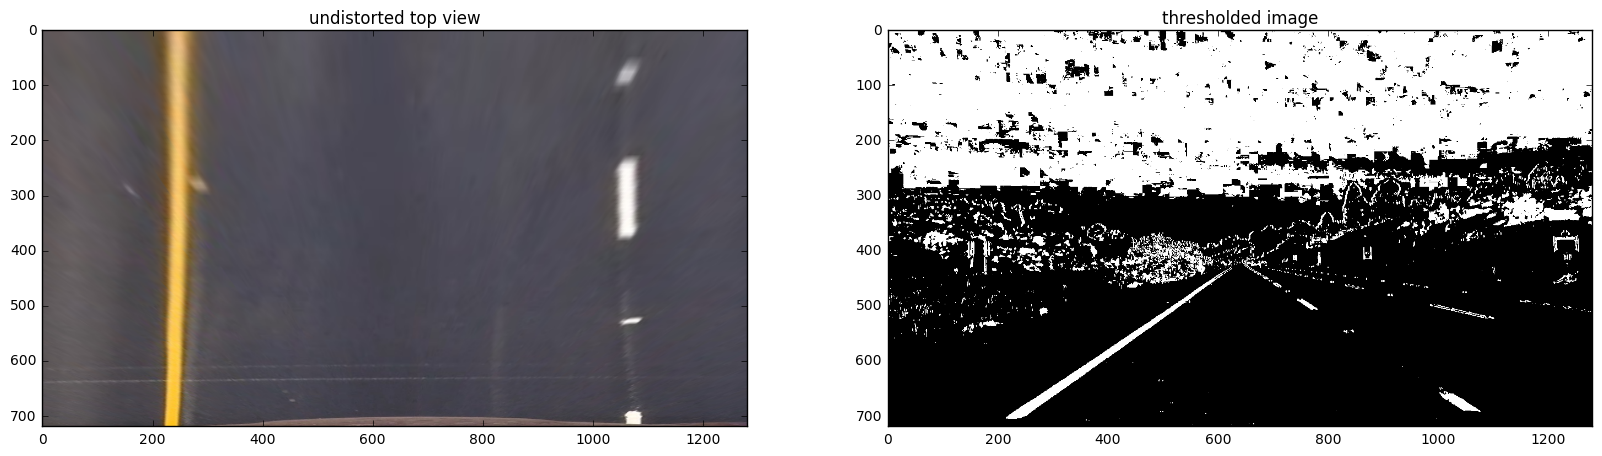

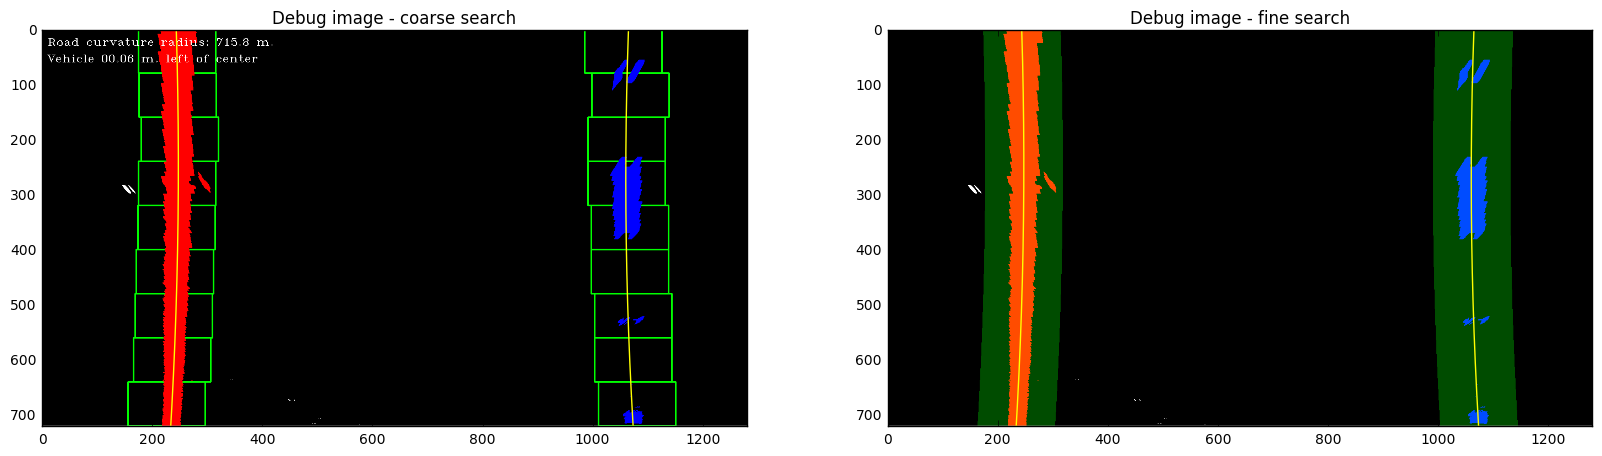

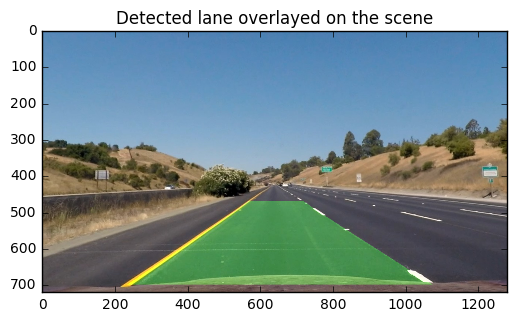

In [9]:
#=====================================================================
# Test individual functions

# Read an image, transform to top view and threshold
image = read_image('./test_images/straight_lines1.jpg')

undistorted = undistort(image, camMat, distParams)

top_view = generate_top_view(undistorted, persMat)

thresholded = threshold(undistorted, gradThreshMin=30, gradThreshMax=255, 
                        satThreshMin = 100, satThreshMax = 255)

binaryTopView = generate_top_view(thresholded, persMat)

# We want to generate debug images
bDebug = True

# Test coarse lane finding
leftX, leftY, rightX, rightY, debugImage = coarse_lane_search(binaryTopView,
                                                    nWindows=9, 
                                                    searchDx=70,
                                                    bDebug=bDebug)

# Fit a second order polynomial to lane pixels (coarse)
leftFit = np.polyfit(leftY, leftX, 2)
rightFit = np.polyfit(rightY, rightX, 2)

# Test fine lane finding
found,leftX, leftY, rightX, rightY, debugImage2 = fine_lane_search(binaryTopView, 
                                                       leftFit, rightFit, 
                                                       searchDx=70, 
                                                       bDebug = bDebug)

# Fit a second order polynomial to lane pixels (fine)
leftFit2 = np.polyfit(leftY, leftX, 2)
rightFit2 = np.polyfit(rightY, rightX, 2)

# Fit a second order polynomial to lane pixels after scaling to real world units (meters)
leftFit_m = np.polyfit(leftY*metersPerPixelY, leftX*metersPerPixelX, 2)
rightFit_m = np.polyfit(rightY*metersPerPixelY, rightX*metersPerPixelX, 2)

# compute radius of curvature of the road and vehicle position relative to lane
radius = get_curvature(leftFit_m, rightFit_m, binaryTopView.shape[0]*metersPerPixelY)
offset = get_offset_from_center(leftFit, rightFit, binaryTopView.shape[1]/2, binaryTopView.shape[0])
print('Road curvature radius: ', radius, 'm.')
print('Vehicle offset from center:', offset*metersPerPixelX, 'm.')

# add measurements to the debug image
text = "Road curvature radius: %05.1f m." % (radius)
cv2.putText(debugImage, text, (10,30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, [255,255,255], 1) 

if offset < 0:
    lr = "left"
else:
    lr = "right"
text = "Vehicle %05.2f m. %s of center" % (np.fabs(offset)*metersPerPixelX, lr)
cv2.putText(debugImage, text, (10,60), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, [255,255,255], 1) 
cv2.imwrite('./output_images/debug_sliding_windows.png', cv2.cvtColor(debugImage, cv2.COLOR_RGB2BGR))

# now plot some figures
f, axarr = plt.subplots(1,2,figsize=(20,10))
axarr[0].imshow(top_view)
axarr[0].set_title('undistorted top view')
axarr[1].imshow(thresholded,cmap='gray')
axarr[1].set_title('thresholded image');

if bDebug is True:
    f, axarr = plt.subplots(1,2,figsize=(20,10))
    plotY = np.linspace(0, binaryTopView.shape[0]-1, binaryTopView.shape[0] )
    leftFitX = leftFit[0]*plotY**2 + leftFit[1]*plotY + leftFit[2]
    rightFitX = rightFit[0]*plotY**2 + rightFit[1]*plotY + rightFit[2]
    axarr[0].imshow(debugImage)
    axarr[0].plot(leftFitX, plotY, color='yellow')
    axarr[0].plot(rightFitX, plotY, color='yellow')
    axarr[0].set_xlim(0, binaryTopView.shape[1])
    axarr[0].set_ylim(binaryTopView.shape[0], 0)
    axarr[0].set_title('Debug image - coarse search')

    leftFitX2 = leftFit2[0]*plotY**2 + leftFit2[1]*plotY + leftFit2[2]
    rightFitX2 = rightFit2[0]*plotY**2 + rightFit2[1]*plotY + rightFit2[2]
    axarr[1].imshow(debugImage2)
    axarr[1].plot(leftFitX2, plotY, color='yellow')
    axarr[1].plot(rightFitX2, plotY, color='yellow')
    axarr[1].set_xlim(0, binaryTopView.shape[1])
    axarr[1].set_ylim(binaryTopView.shape[0], 0)
    axarr[1].set_title('Debug image - fine search')
    f.savefig('./output_images/debug_lane_search.png')

# back-project the extracted lane into the original distortion-corrected image 
overlay = back_project(binaryTopView, leftFit, rightFit, invPersMat)
overlayedScene = cv2.addWeighted(undistorted, 1, overlay, 0.3, 0)
plt.figure()
plt.imshow(overlayedScene)
plt.title('Detected lane overlayed on the scene')
plt.savefig('./output_images/debug_lane_overlayed.png')


In [10]:
#=====================================================================
# The processing pipeline

global global_init_search
global global_leftFit
global global_rightFit
global global_debug_flag

# reset global variables
global_init_search = True
global_leftFit = np.array([0, 0, 0])
global_rightFit = np.array([0, 0, 0])
global_debug_flag = True

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    
    global global_init_search
    global global_leftFit
    global global_rightFit
    global global_debug_flag

    # apply distortion correction, find lane pixels and transform to top view
    undistorted = undistort(image, camMat, distParams)
    thresholded = threshold(undistorted, gradThreshMin=30, gradThreshMax=255, 
                            satThreshMin = 100, satThreshMax = 255)
    binary_plan = generate_top_view(thresholded, persMat)

    # if this is the first frame or if we lost lanes, re-initialise with a coarse search for lanes
    if global_init_search is True:
        leftX, leftY, rightX, rightY, debugImage = coarse_lane_search(binary_plan, 
                                                                       nWindows=9,
                                                                       searchDx=70,
                                                                       bDebug=global_debug_flag)
        global_init_search = False
        global_leftFit = np.polyfit(leftY, leftX, 2)
        global_rightFit = np.polyfit(rightY, rightX, 2)
    
    # already know roughly where lanes are. do fine search
    else:
        global_init_search, leftX, leftY, rightX, rightY, debugImage = fine_lane_search(binary_plan,
                                                                                         global_leftFit, 
                                                                                         global_rightFit,
                                                                                         bDebug=global_debug_flag)
    
    # if search succeeded, update curvature parameters
    if global_init_search is False:
        leftFit = np.polyfit(leftY, leftX, 2)
        rightFit = np.polyfit(rightY, rightX, 2)
        
        # apply temporal smoothing with exponential filter
        alpha = 0.8
        global_leftFit = global_leftFit * alpha + leftFit * (1 - alpha)
        global_rightFit = global_rightFit * alpha + rightFit * (1 - alpha)

        # Fit a second order polynomial to lane pixels after scaling to real world units (meters)
        leftFit_m = np.polyfit(leftY*metersPerPixelY, leftX*metersPerPixelX, 2)
        rightFit_m = np.polyfit(rightY*metersPerPixelY, rightX*metersPerPixelX, 2)

        # Find the radius of curvature and vehicle offset from lane center
        radius = get_curvature(leftFit_m, rightFit_m, binary_plan.shape[0]*metersPerPixelY)
        offset = get_offset_from_center(leftFit, rightFit, binary_plan.shape[1]/2, binary_plan.shape[0])

        text = "Road curvature radius: %05.1f m." % (radius)
        cv2.putText(debugImage, text, (10,30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, [255,255,255], 1) 

        if offset < 0:
            lr = "left"
        else:
            lr = "right"
        text = "Vehicle %05.2f m. %s of center" % (np.fabs(offset)*metersPerPixelX, lr)
        cv2.putText(debugImage, text, (10,60), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, [255,255,255], 1) 


    # overlay lane and vehicle information on output image
    overlay = back_project(binary_plan, global_leftFit, global_rightFit, invPersMat)
    result = cv2.addWeighted(undistorted, 1, overlay, 0.3, 0)
   
    return debugImage

In [11]:
#=====================================================================
# process the project video

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# set inputs and putputs
output_video_name = 'output.mp4'
input_video = VideoFileClip("project_video.mp4")

global global_init_search
global global_leftFit
global global_rightFit
global global_debug_flag

# reset global variables
global_init_search = True
global_leftFit = np.array([0, 0, 0])
global_rightFit = np.array([0, 0, 0])
global_debug_flag = True

output_video = input_video.fl_image(process_image)
%time output_video.write_videofile(output_video_name, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [03:42<00:00,  5.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 27min 7s, sys: 43.2 s, total: 27min 50s
Wall time: 3min 43s
